# Lineal Regression a+b(x)
# Numpy and Pandas 

# 1. Training data set 
# 2. Validation data set
# 3. Test data set


In [148]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn import metrics 
dat = yf.Ticker("NVDA")
df = yf.download(["NVDA"], period='12mo', interval='1d') # Por hora o por minuto, o por dia 
df[('Prev Close', 'NVDA')] = df[('Close', 'NVDA')].shift(1)  # Shifted by 1 to use previous day's close to predict today's
df.dropna(inplace=True)  # Remove rows with NaN values
df.tail()
# df['Prev Close']

# dat.calendar
# dat.analyst_price_targets
# dat.quarterly_income_stmt
# dat.history(period='1mo')
# dat.option_chain(dat.options[0]).calls




[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Prev Close
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2025-03-26,113.760002,118.839996,112.709999,118.730003,293463300,120.690002
2025-03-27,111.430000,114.449997,110.660004,111.349998,236902100,113.760002
2025-03-28,109.669998,112.870003,109.070000,111.489998,229872500,111.430000
2025-03-31,108.379997,110.959999,103.650002,105.129997,298611800,109.669998
2025-04-01,107.750000,109.093697,106.800003,108.532997,31867332,108.379997


In [149]:
import pyodbc 


try:
    with pyodbc.connect(r'DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost;DATABASE=stock_market;Trusted_Connection=yes;')  as conn: # Si se pierde la conexion, cierra la sesion
        cursor = conn.cursor()
        # Method 2: Using itertuples() - faster than iterrows()
        for row in df.itertuples():
            print(f"Index: {row.Index}")
            print(row)
            
            data = {
                'ticker': 'NVDA',
                'date': row.Index,
                'close': row[1],
                'high': row[2],
                'low': row[3],
                'open': row[4],
                'volume': row[5]
            }
            print(data)
            cursor.execute("""
                INSERT INTO StockPrices (Ticker, "Date", "Close", "High", "Low", "Open", Volume)
                SELECT ?, ?, ?, ?, ?, ?, ?
                WHERE NOT EXISTS (
                    SELECT 1 FROM StockPrices 
                    WHERE Ticker = ? AND Date = ?
                )
            """, 
            data['ticker'], data['date'], data['close'], data['high'],
            data['low'], data['open'], data['volume'],
            data['ticker'], data['date'])

            cursor.execute("""
            UPDATE StockPrices
            SET     
                "Close" = COALESCE("Close", ?),
                "High" = COALESCE("High", ?),
                "Low" = COALESCE("Low", ?),
                "Open" = COALESCE("Open", ?),
                "Volume" = COALESCE("Volume", ?)
            WHERE Ticker = ? AND "Date" = ?
            """, data['close'], data['high'],
            data['low'], data['open'], data['volume'], data['ticker'], data["date"])
        
            if cursor.rowcount > 0:
                print("New record inserted successfully")
            else:
                print("Record already exists - no insertion made")
            
except pyodbc.Error as e:
    print(f"Database error: {e}")



Index: 2024-04-02 00:00:00
Pandas(Index=Timestamp('2024-04-02 00:00:00'), _1=89.42261505126953, _2=90.06440242112468, _3=87.59121620163441, _4=88.41893947358703, _5=433064000, _6=90.33331298828125)
{'ticker': 'NVDA', 'date': Timestamp('2024-04-02 00:00:00'), 'close': 89.42261505126953, 'high': 90.06440242112468, 'low': 87.59121620163441, 'open': 88.41893947358703, 'volume': 433064000}
New record inserted successfully
Index: 2024-04-03 00:00:00
Pandas(Index=Timestamp('2024-04-03 00:00:00'), _1=88.93477630615234, _2=90.3443168469122, _3=88.3709661913593, _4=88.45493823513225, _5=370067000, _6=89.42261505126953)
{'ticker': 'NVDA', 'date': Timestamp('2024-04-03 00:00:00'), 'close': 88.93477630615234, 'high': 90.3443168469122, 'low': 88.3709661913593, 'open': 88.45493823513225, 'volume': 370067000}
New record inserted successfully
Index: 2024-04-04 00:00:00
Pandas(Index=Timestamp('2024-04-04 00:00:00'), _1=85.87677764892578, _2=90.60422800372173, _3=85.85178433643762, _4=90.37629845117095, 

In [150]:
x = df["Prev Close"]
y = df["Close"]

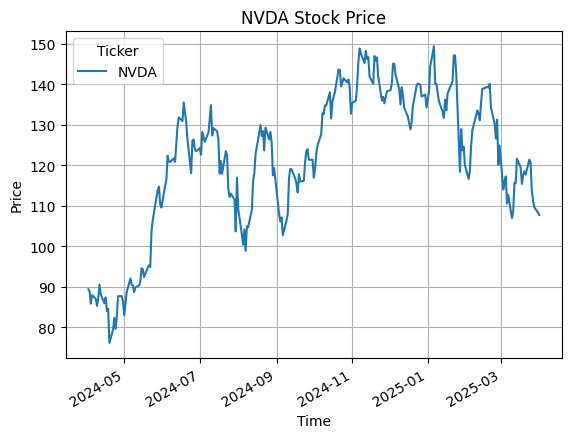

In [151]:
df["Close"].plot()
plt.title("NVDA Stock Price")
plt.ylabel("Price")
plt.xlabel("Time")
plt.grid(which="major")

In [152]:
def CreateTrainTestSet(x, y):
    features = x
    target = y

    data_len = x.shape[0]

    print("Historical data length: ", data_len)

    train_split = int(data_len * 0.88) # 88% training data
    print("Training data len: ", train_split)
    val_split = train_split + int(data_len * 0.1) # 10%
    print("Validation Set Len", val_split)
    X_train, X_val, X_test = features[:train_split], features[train_split:val_split], features[val_split:]
    Y_train, Y_val, Y_test = target[:train_split], target[train_split:val_split], target[val_split:]

    return X_train, X_val, X_test, Y_train, Y_val, Y_test


X_train, X_val, X_test, Y_train, Y_val, Y_test = CreateTrainTestSet(x, y)

Historical data length:  251
Training data len:  220
Validation Set Len 245


In [153]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() 
model.fit(X_train, Y_train)

LinearRegression()

In [154]:
print("Performance (R^2):" , model.score(X_train, Y_train))

Performance (R^2): 0.9495422655065606


In [155]:
def get_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np. array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) *100

In [156]:
Y_train_pred = model.predict(X_train)
Y_val_pred = model.predict(X_val)
Y_test_pred = model.predict(X_test)


In [157]:
# print("Training R-squared: ",round(metrics.r2_score(Y_train,Y_train_pred),2))
# print("Training Explained Variation: ",round(metrics.explained_variance_score(Y_train,Y_train_pred),2))
# print('Training MAPE:', round(get_mape(Y_train,Y_train_pred), 2)) 
# print('Training Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
# print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_train,Y_train_pred)),2))
# print("Training MAE: ",round(metrics.mean_absolute_error(Y_train,Y_train_pred),2))

# print(' ')

# print("Validation R-squared: ",round(metrics.r2_score(Y_val,Y_val_pred),2))
# print("Validation Explained Variation: ",round(metrics.explained_variance_score(Y_val,Y_val_pred),2))
# print('Validation MAPE:', round(get_mape(Y_val,Y_val_pred), 2)) 
# print('Validation Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
# print("Validation RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_val,Y_val_pred)),2))
# print("Validation MAE: ",round(metrics.mean_absolute_error(Y_val,Y_val_pred),2))

# print(' ')

# print("Test R-squared: ",round(metrics.r2_score(Y_test,Y_test_pred),2))
# print("Test Explained Variation: ",round(metrics.explained_variance_score(Y_test,Y_test_pred),2))
# print('Test MAPE:', round(get_mape(Y_test,Y_test_pred), 2)) 
# print('Test Mean Squared Error:', round(metrics.mean_squared_error(Y_test,Y_test_pred), 2)) 
# print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_test,Y_test_pred)),2))
# print("Test MAE: ",round(metrics.mean_absolute_error(Y_test,Y_test_pred),2))

In [158]:
# df_pred = pd.DataFrame(Y_val.values, columns=['Actual'], index=Y_val.index)
# df_pred['Predicted'] = Y_val_pred
# df_pred = df_pred.reset_index()
# df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
# df_pred

# Predicting tomorrows Stock Price

In [159]:
# Y_test.loc[-1] = Y_test.tail(1)
# df[('Prev Close', 'NVDA')] = df[('Close', 'NVDA')].shift(1)  # Shifted by 1 to use previous day's close to predict today's
# df.dropna(inplace=True)  # Remove rows with NaN values
# tomorrow['Date'] = pd.date_range('3/14/2025', periods = 1, freq ='D')
# tomorrow = pd.concat([Y_test, pd.DataFrame(
#     [{'Date': pd.Timestamp.today()}])]) # .reset_index(drop=True)
import datetime

tomorrow = Y_test.tail(1)
tomorrowsDate = datetime.date.today() + datetime.timedelta(days=1)
tomorrow.index = pd.MultiIndex.from_tuples([('NVDA', tomorrowsDate)], names=['Ticker', 'Date'])
tomorrowsPrice = model.predict(tomorrow)
df_pred = pd.DataFrame(tomorrow.values, columns=["Predicted"], index=tomorrow.index)
df_pred['Predicted'] = tomorrowsPrice
df_pred = df_pred.reset_index()
df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
df_pred
print(tomorrow)


Ticker               NVDA
Ticker Date              
NVDA   2025-04-02  107.75


In [160]:
# Read the pickle file
global predictions_df
try:
    predictions_df = pd.read_pickle('predictions.pkl')
    print(predictions_df)
    # Check if date already exists
    # Check if '2025-03-26' exists in the 'Ticker Date' level
    date_to_check = pd.to_datetime(tomorrowsDate)
    exists = date_to_check in pd.to_datetime(predictions_df.index.get_level_values('Date'))
    predictions_df.index.get_level_values('Date')
    if not exists:
        predictions_df = pd.concat([predictions_df, tomorrow])
        predictions_df.to_pickle('predictions.pkl')
except FileNotFoundError:
    print("predictions.pkl not found")
    print("No predictions found")
    tomorrow.to_pickle('predictions.pkl')
    print(tomorrow)



Ticker                   NVDA
Ticker Date                  
NVDA   2025-03-26  120.178596
       2025-03-29  109.669998
       2025-03-30  109.669998


In [161]:
import pyodbc 


with pyodbc.connect(r'DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost;DATABASE=stock_market;Trusted_Connection=yes;')  as conn: # Si se pierde la conexion, cierra la sesion
    cursor = conn.cursor()
    # Method 2: Using itertuples() - faster than iterrows()
    for row in predictions_df.itertuples():
        print(f"Index: {row.Index}")
        print(row)
        print(f"Price: {row[0]}")
        print("-" * 30)
        [print(val) for val in row]
        data = (
            'NVDA',
            row.Index[1],
            row[1],
            'NVDA',
            row.Index[1]
        )
        cursor.execute("""
            INSERT INTO StockPrices (Ticker, "Date", Prediction)
            SELECT ?, ?, ?
            WHERE NOT EXISTS (
                SELECT 1 FROM StockPrices 
                WHERE Ticker = ? AND Date = ?
            )           
        """, 
        data)
    
        if cursor.rowcount > 0:
            print("New record inserted successfully")
        else:
            print("Record already exists - no insertion made")

Index: ('NVDA', datetime.date(2025, 3, 26))
Pandas(Index=('NVDA', datetime.date(2025, 3, 26)), NVDA=120.17859649658203)
Price: ('NVDA', datetime.date(2025, 3, 26))
------------------------------
('NVDA', datetime.date(2025, 3, 26))
120.17859649658203
Record already exists - no insertion made
Index: ('NVDA', datetime.date(2025, 3, 29))
Pandas(Index=('NVDA', datetime.date(2025, 3, 29)), NVDA=109.66999816894531)
Price: ('NVDA', datetime.date(2025, 3, 29))
------------------------------
('NVDA', datetime.date(2025, 3, 29))
109.66999816894531
Record already exists - no insertion made
Index: ('NVDA', datetime.date(2025, 3, 30))
Pandas(Index=('NVDA', datetime.date(2025, 3, 30)), NVDA=109.66999816894531)
Price: ('NVDA', datetime.date(2025, 3, 30))
------------------------------
('NVDA', datetime.date(2025, 3, 30))
109.66999816894531
Record already exists - no insertion made
Index: ('NVDA', datetime.date(2025, 4, 2))
Pandas(Index=('NVDA', datetime.date(2025, 4, 2)), NVDA=107.75)
Price: ('NVDA',

> Get latest date 
# Agregar la fecha 
# Agregar 24 horas
- 2025-03-14

In [162]:
# API Twitter X

# Selenium 

